An End-to-End Project on Time Series Analysis and Forecasting with Python

Time series analysis comprises methods for analyzing time series data in order to extract meaningful statistics and other characteristics of the data. Time series forecasting is the use of a model to predict future values based on previously observed values.
Time series are widely used for non-stationary data, like economic, weather, stock price, and retail sales in this post. We will demonstrate different approaches for forecasting retail sales time series. Let’s get started

# The Data
# We are using Flu data that can be downloaded from here.



In [3]:
import warnings
import itertools
import os
import numpy as np
import matplotlib.pyplot as plt
#warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import pandas as pd
import statsmodels.api as sm

#matplotlib.rcParams['axes.labelsize'] = 14
#matplotlib.rcParams['xtick.labelsize'] = 12
#matplotlib.rcParams['ytick.labelsize'] = 12
#matplotlib.rcParams['text.color'] = 'k'

There are several categories in the Superstore sales data, we start from time series analysis and forecasting for furniture sales.

In [4]:
#path = 'C:/Users/shayden/Downloads/'
#os.chdir(path)
#print("Current Working Directory " , os.getcwd())

In [5]:
#National level data
dfx = pd.read_csv(r'https://raw.githubusercontent.com/jjschueder/7333QTW/master/Case%20Study%204/NationalCombined_UpTo_2020.csv')    
#Regional level data
#dfx = pd.read_csv(r'https://raw.githubusercontent.com/jjschueder/7333QTW/master/Case%20Study%204/Combined_2010_to_2020.csv')

In [6]:
dfx

,Year,Week,PositiveCases
0,1997,40,0
1,1997,41,11
2,1997,42,17
3,1997,43,7
4,1997,44,10
...,...,...,...
1180,2020,20,48
1181,2020,21,17
1182,2020,22,14
1183,2020,23,21


In [7]:
dfx.describe()

,Year,Week,PositiveCases
count,1185.000000,1185.000000,1185.000000
mean,2008.596624,26.519831,1560.747679
std,6.570896,15.142169,3653.877099
min,1997.000000,1.000000,0.000000
25%,2003.000000,13.000000,23.000000
50%,2009.000000,26.000000,207.000000
75%,2014.000000,40.000000,1173.000000
max,2020.000000,53.000000,26386.000000


In [8]:
dfx.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1185 entries, 0 to 1184
Data columns (total 3 columns):
Year             1185 non-null int64
Week             1185 non-null int64
PositiveCases    1185 non-null int64
dtypes: int64(3)
memory usage: 27.9 KB


In [9]:
#!python -m pip install --upgrade pandas-profiling
from pandas_profiling import ProfileReport
profile = ProfileReport(dfx, plot={'histogram': {'bins': 8}}, explorative=True)
profile.to_notebook_iframe()

In [10]:
#dropping x values for now should we impute????
#not needed anymore
#dfx = dfx.loc[dfx['PositiveCases'] != 'X']

In [11]:
# not needed anymore
#dfx['TOTAL SPECIMENS'] = dfx['TOTAL SPECIMENS'].astype(np.float64)
#dfx['PERCENT POSITIVE'] = dfx['PERCENT POSITIVE'].astype(np.float64)

In [12]:
dfx['Date'] = pd.to_datetime(dfx.Year.astype(str), format='%Y') + \
             pd.to_timedelta(dfx.Week.mul(7).astype(str) + ' days')

#dfx['PERCENT POSITIVE DEC'] = dfx['PERCENT POSITIVE'] / 100
#dfx['COUNT POSITIVE'] = dfx['TOTAL SPECIMENS'] * dfx['PERCENT POSITIVE DEC']
#created this column so the rest of the code did not need to be replaced. 
dfx['COUNT POSITIVE']=dfx['PositiveCases']

In [13]:
dfx

,Year,Week,PositiveCases,Date,COUNT POSITIVE
0,1997,40,0,1997-10-08,0
1,1997,41,11,1997-10-15,11
2,1997,42,17,1997-10-22,17
3,1997,43,7,1997-10-29,7
4,1997,44,10,1997-11-05,10
...,...,...,...,...,...
1180,2020,20,48,2020-05-20,48
1181,2020,21,17,2020-05-27,17
1182,2020,22,14,2020-06-03,14
1183,2020,23,21,2020-06-10,21


In [14]:
dfx['Date'].min(), dfx['Date'].max()

(Timestamp('1997-10-08 00:00:00'), Timestamp('2020-06-17 00:00:00'))

Data Preprocessing
This step includes removing columns we do not need, check missing values, aggregate sales by date and so on.

In [15]:
#cols = ['Row ID', 'Order ID', 'Ship Date', 'Ship Mode', 'Customer ID', 'Customer Name', 'Segment', 'Country', 'City', 'State', 'Postal Code', 'Region', 'Product ID', 'Category', 'Sub-Category', 'Product Name', 'Quantity', 'Discount', 'Profit']
#furniture.drop(cols, axis=1, inplace=True)
dfx = dfx.sort_values('Date')
dfx.isnull().sum()

Year              0
Week              0
PositiveCases     0
Date              0
COUNT POSITIVE    0
dtype: int64

In [16]:
dfx2 = dfx.groupby('Date')['COUNT POSITIVE'].sum().reset_index()
dfx2

,Date,COUNT POSITIVE
0,1997-10-08,0
1,1997-10-15,11
2,1997-10-22,17
3,1997-10-29,7
4,1997-11-05,10
...,...,...
1180,2020-05-20,48
1181,2020-05-27,17
1182,2020-06-03,14
1183,2020-06-10,21


# Indexing with Time Series Data

In [17]:
dfx2 = dfx2.set_index('Date')
dfx2.index

DatetimeIndex(['1997-10-08', '1997-10-15', '1997-10-22', '1997-10-29',
               '1997-11-05', '1997-11-12', '1997-11-19', '1997-11-26',
               '1997-12-03', '1997-12-10',
               ...
               '2020-04-15', '2020-04-22', '2020-04-29', '2020-05-06',
               '2020-05-13', '2020-05-20', '2020-05-27', '2020-06-03',
               '2020-06-10', '2020-06-17'],
              dtype='datetime64[ns]', name='Date', length=1185, freq=None)

Our current datetime data can be tricky to work with, therefore, we will use the averages daily sales value for that month instead, and we are using the start of each month as the timestamp.

In [18]:
y = dfx2['COUNT POSITIVE'].resample('MS').mean()

Have a quick peek 2017 furniture sales data.

In [19]:
y['2010':]

Date
2010-01-01      425.25
2010-02-01      408.00
2010-03-01      394.25
2010-04-01      103.00
2010-05-01       15.75
                ...   
2020-02-01    23910.00
2020-03-01    13386.50
2020-04-01      363.20
2020-05-01       44.00
2020-06-01       15.00
Freq: MS, Name: COUNT POSITIVE, Length: 126, dtype: float64

# Visualizing Flu Cases Time Series Data

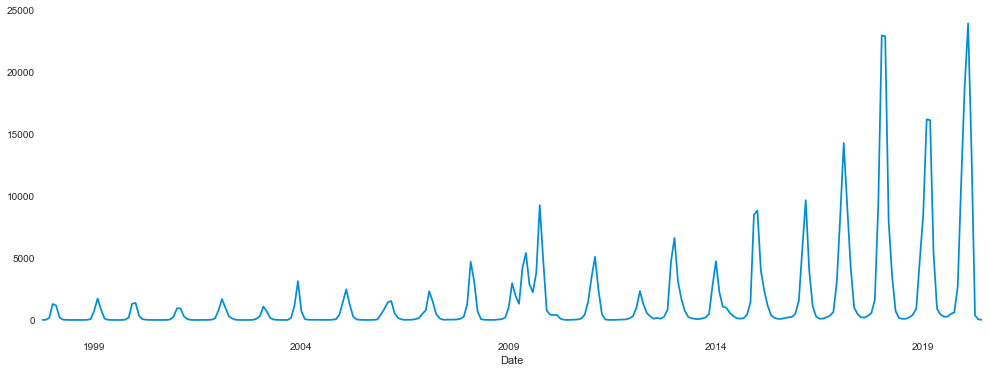

In [20]:
#import tkinter
#import matplotlib
#matplotlib.use('TkAgg')
%matplotlib inline
y.plot(figsize=(15, 6))
plt.show()

Some distinguishable patterns appear when we plot the data. The time-series has seasonality pattern, such as sales are always low at the beginning of the year and high at the end of the year. There is always an upward trend within any single year with a couple of low months in the mid of the year.

We can also visualize our data using a method called time-series decomposition that allows us to decompose our time series into three distinct components: trend, seasonality, and noise.

C:\Users\jjsch\.conda\envs\ML7331\lib\site-packages\pandas\plotting\_matplotlib\tools.py:307: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
C:\Users\jjsch\.conda\envs\ML7331\lib\site-packages\pandas\plotting\_matplotlib\tools.py:307: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
C:\Users\jjsch\.conda\envs\ML7331\lib\site-packages\pandas\plotting\_matplotlib\tools.py:313: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  if not layout[ax.rowNum + 1, ax.colNum]:
C:\Users\jjsch\.conda\envs\ML7331\lib\

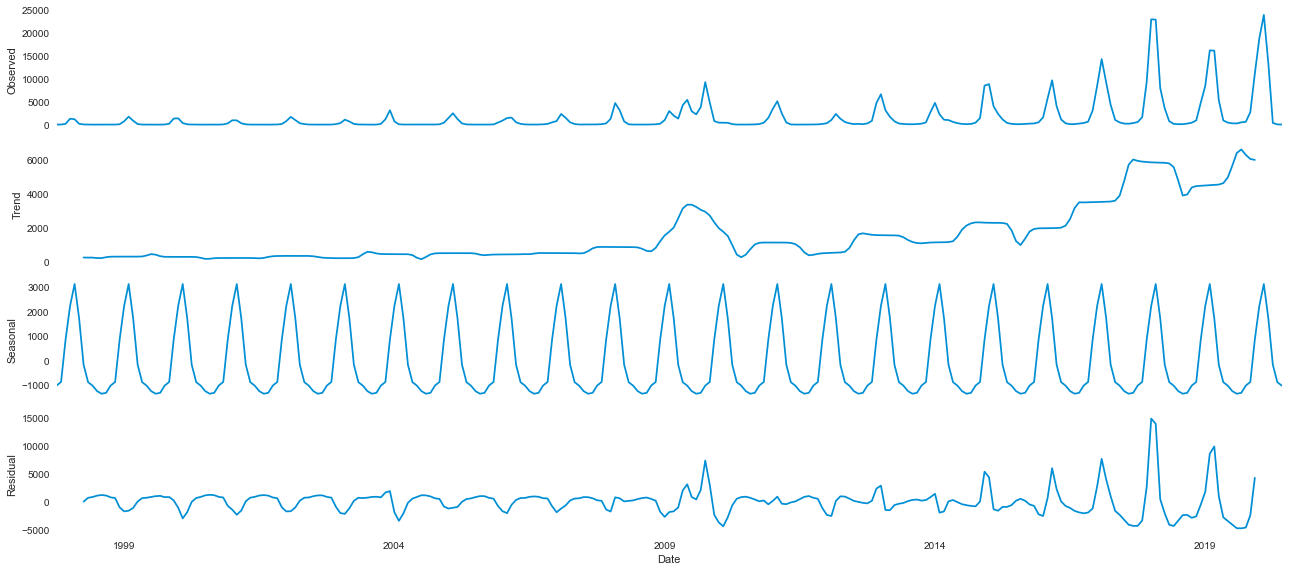

In [21]:
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(y, model='additive')
fig = decomposition.plot()
plt.show()

The plot above clearly shows that the sales of furniture is unstable, along with its obvious seasonality.

# Time series forecasting with ARIMA
We are going to apply one of the most commonly used method for time-series forecasting, known as ARIMA, which stands for Autoregressive Integrated Moving Average.
ARIMA models are denoted with the notation ARIMA(p, d, q). These three parameters account for seasonality, trend, and noise in data:

In [22]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


This step is parameter Selection for our furniture’s sales ARIMA Time Series Model. Our goal here is to use a “grid search” to find the optimal set of parameters that yields the best performance for our model.

In [23]:
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue
            
            df = pd.DataFrame('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:5280.776368560619
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:4959.315582673365
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:4841.691154646756
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:4582.520782903085
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:4856.862194631212
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:4743.998273829064
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:4584.1530775049905
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:4566.575607978051
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:5009.818193290178
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:4708.406166576706
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:4652.498453200149
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:4393.051624096916
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:4672.032927021808
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:4547.688806255014
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:4433.548680109954
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:4392.464134555283
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:5007.1167952647575
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:4765.29877344284
ARIMA(0, 

#ARIMA(1, 0, 1)x(1, 1, 1, 12)12 - AIC
#ARIMA(1, 0, 1)x(0, 1, 1, 12)12 - AIC	4370.278658

The above output suggests that SARIMAX(1, 0, 1)x(0, 1, 1, 12) yields the lowest AIC value of 4370.278658. Therefore we should consider this to be optimal option.

# Fitting the ARIMA model

In [26]:
mod = sm.tsa.statespace.SARIMAX(y,
                                order=(1, 0, 1),
                                seasonal_order=(0, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3394      0.044      7.787      0.000       0.254       0.425
ma.L1          0.7069      0.042     16.957      0.000       0.625       0.789
ma.S.L12      -0.5789      0.031    -18.899      0.000      -0.639      -0.519
sigma2      2.734e+06   1.35e+05     20.277      0.000    2.47e+06       3e+06


We should always run model diagnostics to investigate any unusual behavior.

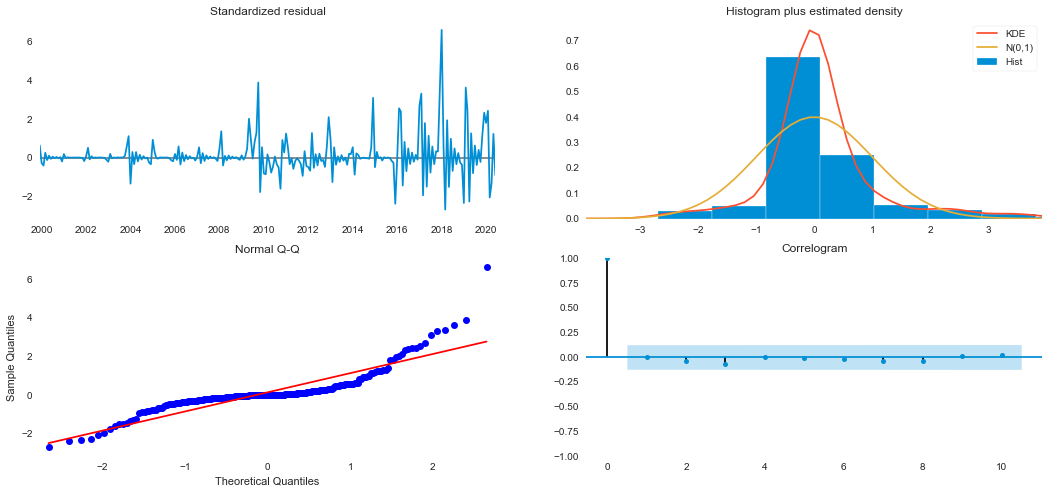

In [27]:
results.plot_diagnostics(figsize=(16, 8))
plt.show()

It is not perfect, however, our model diagnostics suggests that the model residuals are near normally distributed.

# Validating forecasts
To help us understand the accuracy of our forecasts, we compare predicted values to real values of the time series, and we set forecasts to start at 2017–01–01 to the end of the data.

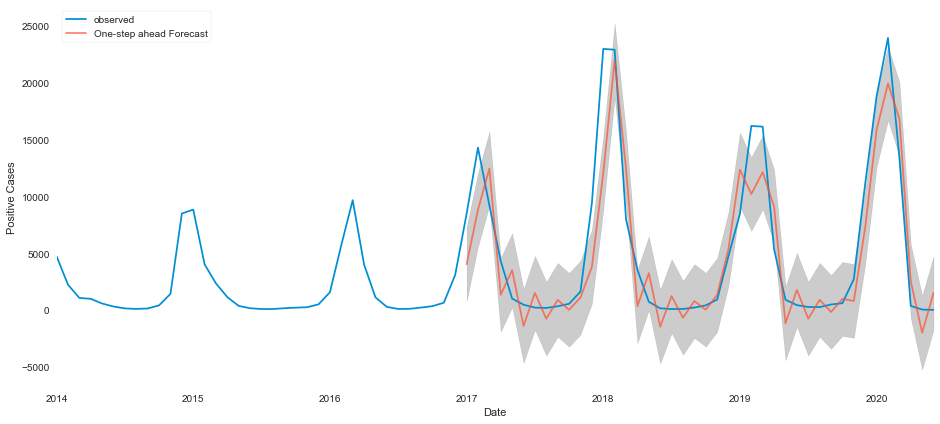

In [28]:
pred = results.get_prediction(start=pd.to_datetime('2017-01-01'), dynamic=False)
pred_ci = pred.conf_int()
ax = y['2014':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Positive Cases')
plt.legend()
plt.show()

The line plot is showing the observed values compared to the rolling forecast predictions. Overall, our forecasts align with the true values very well, showing an upward trend starts from the beginning of the year and captured the seasonality toward the end of the year.

In [29]:
y_forecasted = pred.predicted_mean
y_truth = y['2017-01-01':]
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 10231494.68


In [30]:
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Root Mean Squared Error of our forecasts is 3198.67


In statistics, the mean squared error (MSE) of an estimator measures the average of the squares of the errors — that is, the average squared difference between the estimated values and what is estimated. The MSE is a measure of the quality of an estimator — it is always non-negative, and the smaller the MSE, the closer we are to finding the line of best fit.

Root Mean Square Error (RMSE) tells us that our model was able to forecast the average weekly positive cases in the test set within **151.64 of the real sales. Our furniture daily sales range from around 400 to over 1200. In my opinion, this is a pretty good model so far.**

# Producing and visualizing forecasts

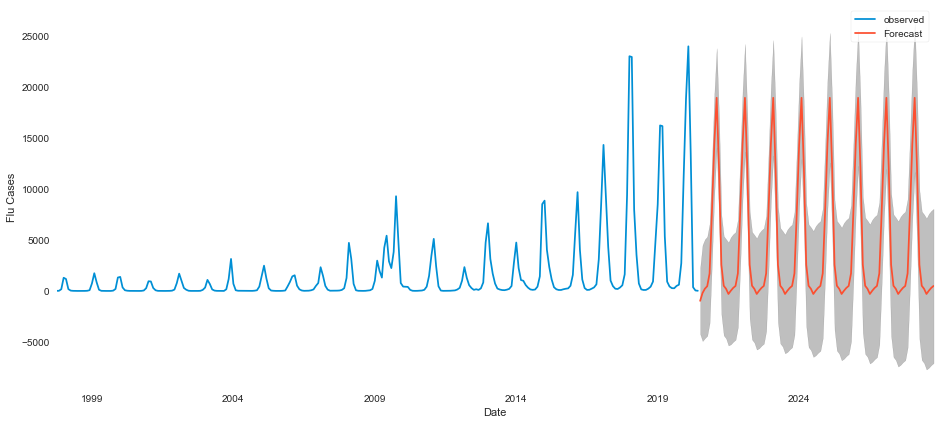

In [31]:
pred_uc = results.get_forecast(steps=100)
pred_ci = pred_uc.conf_int()
ax = y.plot(label='observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Flu Cases')
plt.legend()
plt.show()

Our model clearly captured furniture sales seasonality. As we forecast further out into the future, it is natural for us to become less confident in our values. This is reflected by the confidence intervals generated by our model, which grow larger as we move further out into the future.

The above time series analysis for furniture makes me curious about other categories, and how do they compare with each other over time. Therefore, we are going to compare time series of furniture and office supplier.